### Forecasting Analysis

#### Solution Approach Brief
- Perform a time series analysis on the stock price of a company and predict the future stock price. We have selected Apple Inc. (AAPL) as the company for this analysis.
- We will be using the market data from Yahoo! Finance's API to collect the data for the time period of Jan 2020 - Aug 2025.
- We plan to forecast for next 365 days forecast horizon using this data.


#### Install and Import Libraries

In [35]:
# !pip install yfinance pandas numpy matplotlib statsmodels pmdarima scikit-learn prophet warnings

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


### Question 1
#### Identify the Timeseries Dataset

In [37]:
# Apple stock data pulled from Yahoo Finance for the specified perios and time interval granularity
## API Link - https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download
aapl = yf.download(   tickers = "AAPL" # Company identifier
                    , start="2019-12-31" # period start date (Starting from 31 dec 2019 as we found Jan 1 data missing
                                         # we need to use 31 Devc data to fill the time series values)
                    , end="2025-09-01" # period end date
                    , interval="1D" # time interval granularity
                    , keepna=True # to get complete data including the Null Values which we can treat in our EDA
                    , rounding=True) # rounding the price to 2 decimal point
# Save to base data from API into CSV
col_order = ['Open', 'Close', 'High', 'Low', 'Volume']
aapl = aapl[col_order] # to reordeer the columns to make it more readable
aapl.to_csv("AAPL_time_series.csv", header=True)
aapl.describe()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close,High,Low,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1424.000000,1424.000000,1424.000000,1424.000000,1.424000e+03
mean,159.082605,159.242521,160.892472,157.423048,8.667017e+07
std,44.886974,44.933311,45.195990,44.605681,5.182424e+07
min,55.220000,54.320000,55.320000,51.470000,2.323470e+07
25%,130.265000,130.225000,131.517500,128.595000,5.246878e+07
50%,159.245000,159.490000,161.315000,156.825000,7.264835e+07
75%,189.347500,189.692500,190.905000,188.102500,1.030322e+08
max,257.280000,258.100000,259.180000,256.720000,4.265100e+08


- Initially the data has been taken from 2018 but the stock pricess from 2018 to 2020 almost remains same and hence restricting the analysis to the time frame of Jan 2020 to July 2025

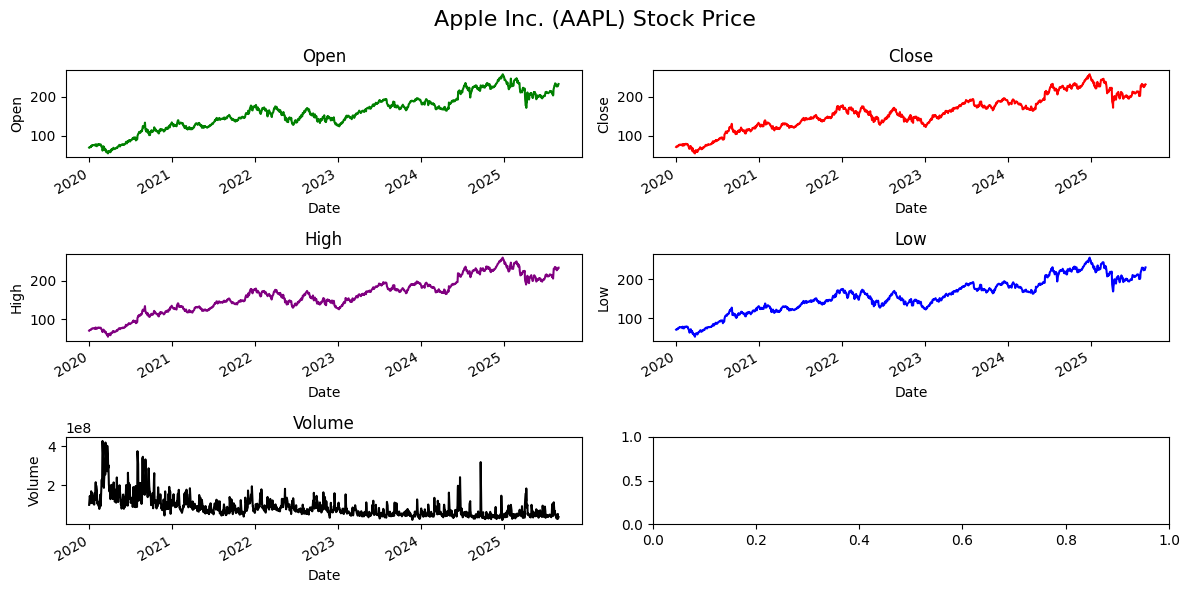

In [38]:
# Function to plot and visualize the timeseries for each column
def plot_eachcolumn(df, columns, title, figsize=(12, 6)):
    # Create figure and subplots
    fig, axes = plt.subplots(int(len(df.columns)/2)+int(len(df.columns)%2), 2, figsize=figsize)
    fig.suptitle(title, fontsize=16)

    color = ['green', 'red', 'purple', 'blue', 'black', 'orange', 'yellow', 'pink', 'brown', 'gray']
    for i, c in enumerate(columns):
        df[c].plot(ax=axes[i//2, i%2], color=color[i], title=c[0])
        axes[i//2, i%2].set_ylabel(c[0])
        axes[i//2, i%2].set_xlabel('Date')

    plt.tight_layout()
    plt.show()

plot_eachcolumn(aapl, aapl.columns, title = 'Apple Inc. (AAPL) Stock Price')


### Question 2
#### Exploratory Data Analysis

Column Definition from API Document -
- Open - Opening price of the stock for the day
- High - Highest price of the stock for the day
- Low - Lowest price of the stock for the day
- Close - Closing price of the stock for the day
- Volume - Number of shares traded

In [39]:
# Null values check
aapl.isna().sum()
assert aapl.isna().sum().sum() == 0
print("No Nulls/Missing data found")

No Nulls/Missing data found


In [40]:
# Duplicate date check
assert aapl.shape[0]==aapl.drop_duplicates().shape[0]
print("No duplicate found")

No duplicate found


In [41]:
# Time series continuity check
test = aapl.copy()
ideal_timeSeries = pd.date_range(start="2019-12-31", end="2025-09-01", freq="D")
print("total dates required :", len(ideal_timeSeries))
print("total dates in the data :", len(test.index))
print("Missing dates:", len(ideal_timeSeries) - len(test.index))

# Checking for continuty in the timeseries
if(len(ideal_timeSeries) - len(test.index) == 0):
    print("Data is continuous")
else:
    print("Data is not continuous")


total dates required : 2072
total dates in the data : 1424
Missing dates: 648
Data is not continuous


- we have 638 date gaps in the time series for the stock price. Mostly they are the weekends and holidays of the year
- we add these date and backfill the missing values
  - for all price columns we use the previous day's closing price essentially making the change in price 0
  - for volume we set the date's value as 0 essentially saying we did no volume trade on those days


In [42]:
# Reindex the dataframe to include all dates
test = test.reindex(ideal_timeSeries)
test['Close'] = test['Close'].ffill()
test['High'] = np.where(test['High'].isna(), test['Close'], test['High'])
test['Low'] = np.where(test['Low'].isna(), test['Close'], test['Low'])
test['Open'] = np.where(test['Open'].isna(), test['Close'], test['Open'])
test['Volume'] = test['Volume'].fillna(0)

print("total dates required :", len(ideal_timeSeries))
print("total dates in the data :", len(test.index))
print("Missing dates:", len(ideal_timeSeries) - len(test.index))
# Checking for continuty in the timeseries
if(len(ideal_timeSeries) - len(test.index) == 0):
    print("Data is continuous")
else:
    print("Data is not continuous")

aapl = test.copy()

total dates required : 2072
total dates in the data : 2072
Missing dates: 0
Data is continuous


In [43]:
# adding a new column daily closing percentage change
aapl['daily_closing_pct_change'] = aapl['Close'].pct_change()

In [44]:
aapl.describe()

Price,Open,Close,High,Low,Volume,daily_closing_pct_change
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
count,2072.000000,2072.000000,2072.000000,2072.000000,2.072000e+03,2071.000000
mean,159.292128,159.402032,160.535975,158.151583,5.956483e+07,0.000715
std,45.040389,45.071674,45.254244,44.859894,5.882776e+07,0.016900
min,55.220000,54.320000,55.320000,51.470000,0.000000e+00,-0.128548
25%,129.845000,129.952500,130.917500,128.912500,0.000000e+00,-0.003627
50%,159.570000,159.825000,161.025000,158.530000,5.381585e+07,0.000000
75%,189.637500,189.820000,190.642500,188.827500,8.727982e+07,0.005943
max,257.290000,258.100000,259.180000,257.290000,4.265100e+08,0.153256


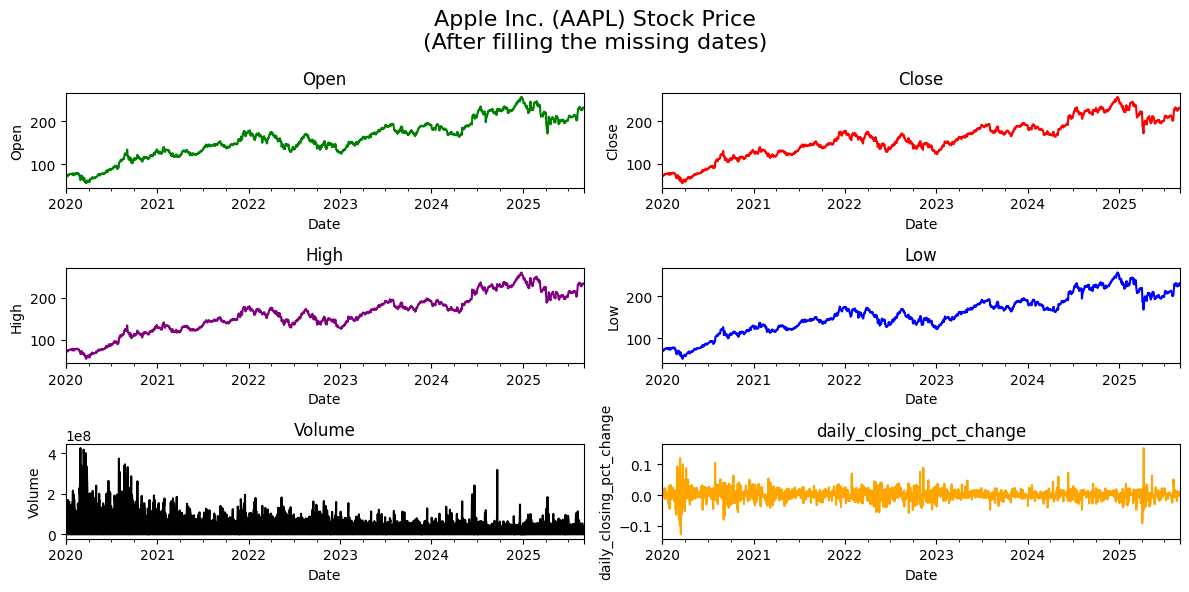

In [45]:
plot_eachcolumn(aapl, aapl.columns, title = 'Apple Inc. (AAPL) Stock Price\n(After filling the missing dates)')

In [46]:
# define the column we want to decompose
metric_of_importance = 'Close'

# remaing the Df to ts (for easy for code writing)
ts = aapl.copy()

# convert the index to datetime
ts.index = pd.to_datetime(ts.index)

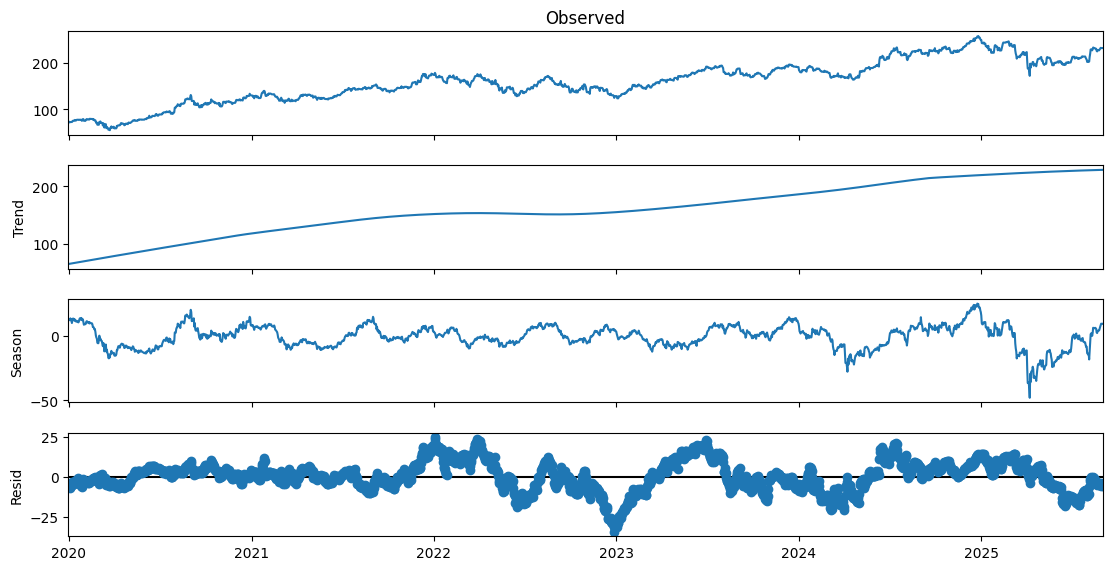

In [47]:
# Season-Trend decomposition using LOESS - https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html
res = STL(ts[metric_of_importance], period=365).fit() # check for seasonality in a 365 days window (Annual pattern)
fig = res.plot()
fig.set_size_inches(12, 6)
plt.show()

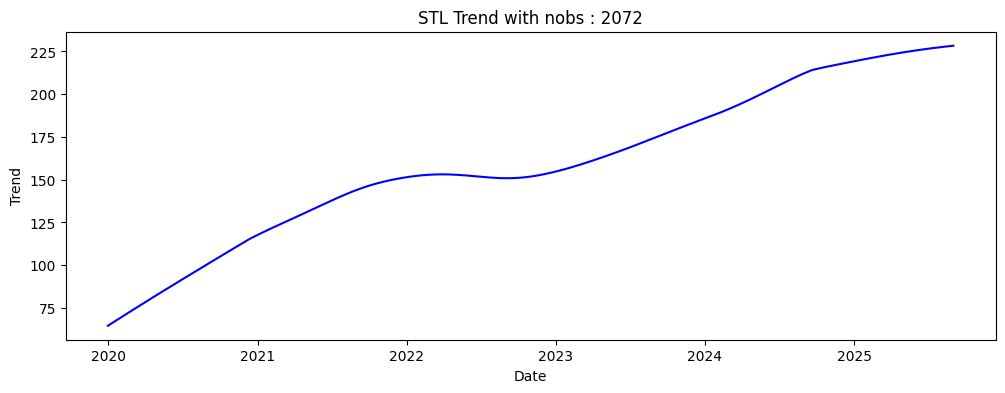

In [48]:
# Trend
plt.figure(figsize=(12,4))
plt.plot(res.trend, color='blue')
plt.title(f'STL Trend with nobs : {res.nobs[0]}')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show()

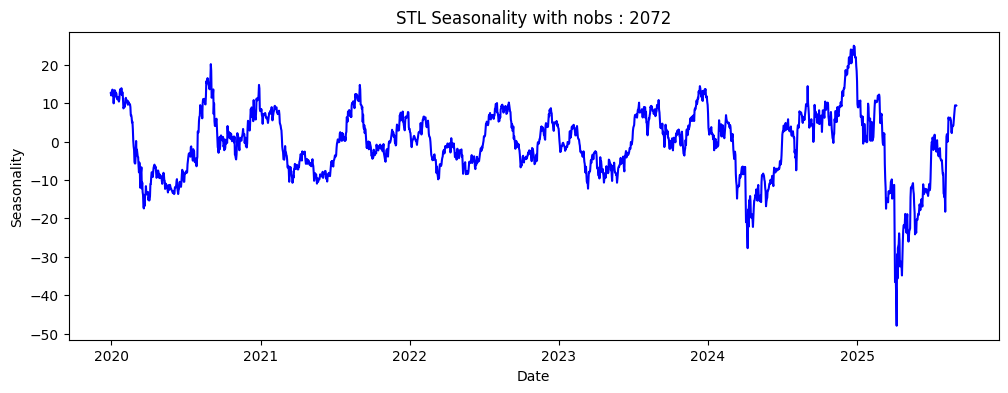

In [49]:
plt.figure(figsize=(12,4))
plt.plot(res.seasonal, color='blue')
plt.title(f'STL Seasonality with nobs : {res.nobs[0]}')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.show()

ADF Test on Residuals 
H0: Residuals are not stationary:
  p-value: 0.002919191791930833, usedlag: 0

Test Outcome : Reject H0 i.e. Residuals are stationary i.e White Noise


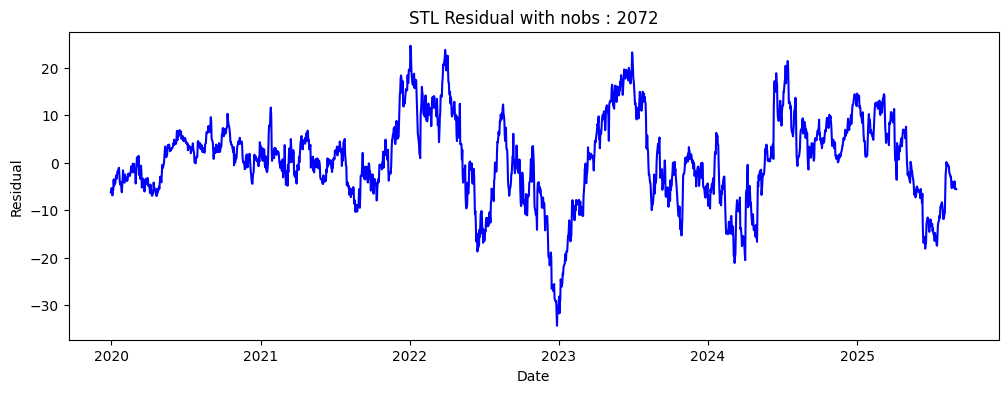

In [50]:
# took help from this Doc https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller
# Residuals
adf_resid = adfuller(res.resid, regression='ct') # Constant and trend order included in regression
print('ADF Test on Residuals \nH0: Residuals are not stationary:')
print(f'  p-value: {adf_resid[1]}, usedlag: {adf_resid[2]}')
if adf_resid[1] < 0.05:
    print('\nTest Outcome : Reject H0 i.e. Residuals are stationary i.e White Noise')
else:
    print('Test Outcome : Cannot reject H0 i.e. Cannot reject that Residuals are non-stationary')

plt.figure(figsize=(12,4))
plt.plot(res.resid, color='blue')
plt.title(f'STL Residual with nobs : {res.nobs[0]}')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

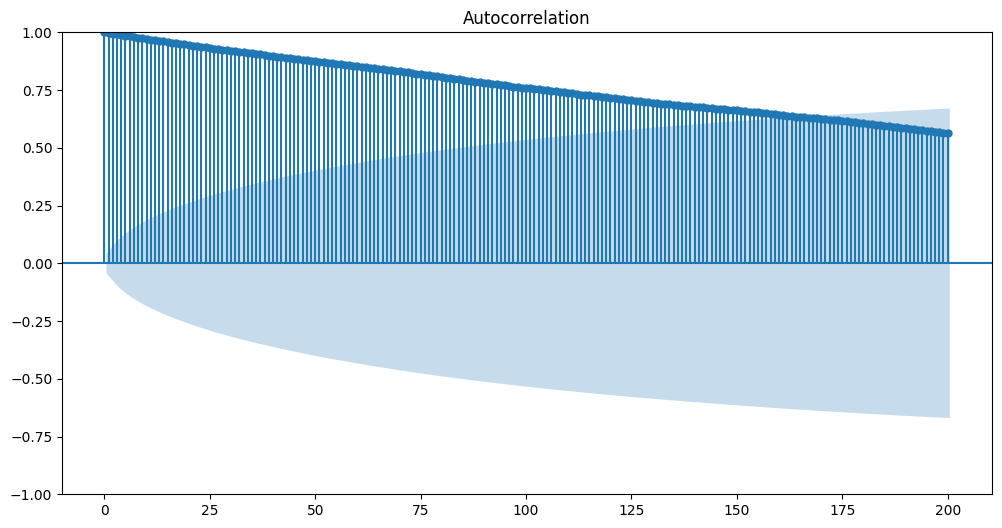

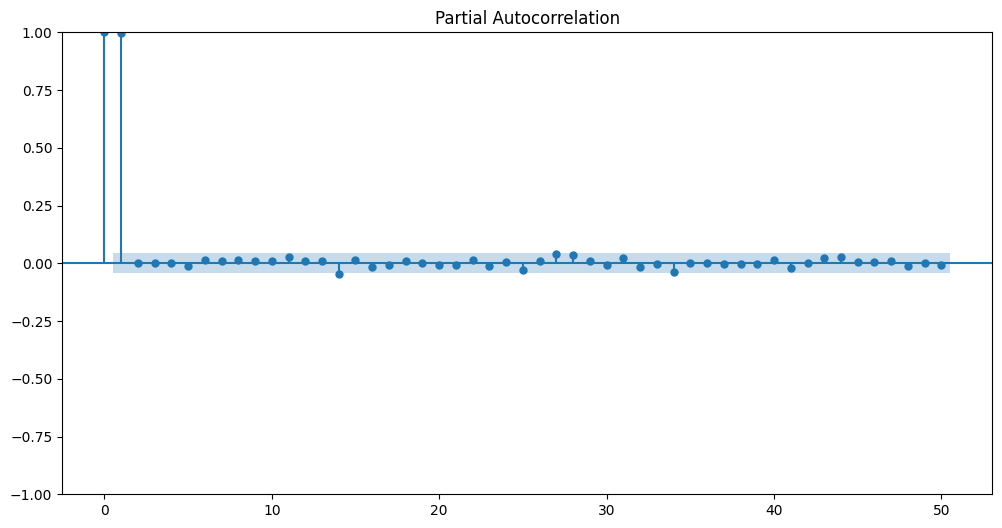

In [51]:
# checking for autocorrelation (ACF plot and PACF plot)
# ACF plot
fig_acf = plot_acf(ts[metric_of_importance], lags=200)
fig_acf.set_size_inches(12, 6)

# PACF plot
fig_pacf = plot_pacf(ts[metric_of_importance], lags=50)
fig_pacf.set_size_inches(12, 6)

plt.show()

- From a Visual inspection on the time series data,
    - Trend : We can clearly see there is a increasing Trend to the time series
    - Seasonality : No Seasonality in a Annual Period visible in ACF Plot
    - Residue : The residue is centered around 0 and the ADF test confirms that the Residue is Stationary and hence White Noise.
    - The ACF plot shows a significant autocorrelation till lag 150 days
    - The PACF plot shows a significant autocorrelation till lag 2 days

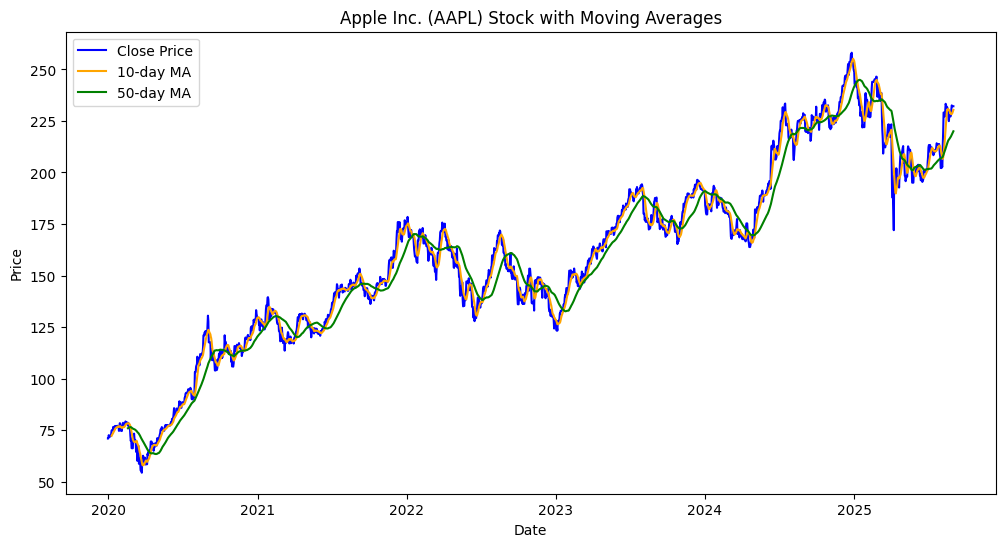

In [52]:
#Moving Averages for seasonlaity check
plt.figure(figsize=(12,6))
plt.plot(ts[metric_of_importance], label='Close Price', color='blue')
plt.plot(ts[metric_of_importance].rolling(window=10).mean(), label='10-day MA', color='orange')
plt.plot(ts[metric_of_importance].rolling(window=50).mean(), label='50-day MA', color='green')
plt.title("Apple Inc. (AAPL) Stock with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### Question 3
#### Smoothing Techniques and forecasting

In [53]:
data = ts[metric_of_importance].astype(float)
data.columns = [metric_of_importance]
data.columns

Index(['Close'], dtype='object')

In [54]:
# Split into train and test (last 365 days for test and days prior to that for train)
max_date = data.index.max()
three_months_before = max_date - pd.DateOffset(days=366)

train = data[data.index <= three_months_before]
test = data[data.index > three_months_before]

print("Train date range:", train.index.min(), train.index.max())
print("Test date range:", test.index.min(), test.index.max())

Train date range: 2019-12-31 00:00:00 2024-08-31 00:00:00
Test date range: 2024-09-01 00:00:00 2025-09-01 00:00:00


In [55]:
# Mean Absolute Scaled Error Function
def mase(y_true, y_pred, y_train):
    y_train = np.array(y_train)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    scale = np.sum((y_train - np.mean(y_train))**2) / len(y_train)
    mase = np.sum(np.abs(y_true - y_pred) * scale) / len(y_true)
    return mase

Moving Average Forecast Value:  201.34913333333333


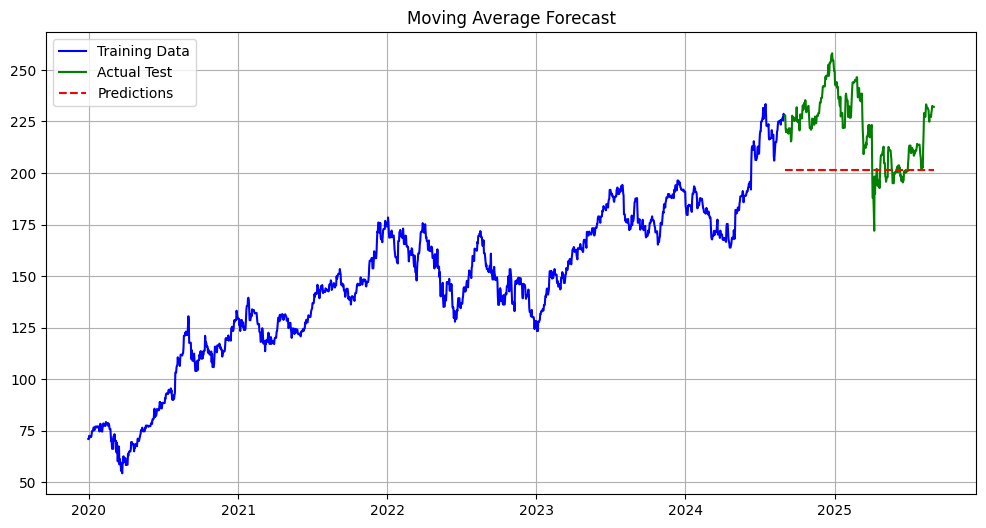

In [56]:
# Moving Average Forecast
ma_window = 150
ma_forecast = train.rolling(ma_window).mean().iloc[-1]
ma_pred = np.repeat(ma_forecast, len(test))
print("Moving Average Forecast Value: ", ma_pred.unique()[0])

# Calculate Error Metrics
ma_mae = mean_absolute_error(test, ma_pred)
ma_rmse = np.sqrt(mean_squared_error(test, ma_pred))
ma_mape = mean_absolute_percentage_error(test, ma_pred)
ma_mase = mase(test, ma_pred, train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, ma_pred, label='Predictions', color='red', linestyle='--')
plt.title("Moving Average Forecast")
plt.legend()
plt.grid(True)
plt.show()


                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Close   No. Observations:                 1706
Model:             SimpleExpSmoothing   SSE                          40788.589
Optimized:                      False   AIC                           5419.272
Trend:                           None   BIC                           5430.156
Seasonal:                        None   AICC                          5419.296
Seasonal Periods:                None   Date:                 Sun, 14 Sep 2025
Box-Cox:                        False   Time:                         13:03:23
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
initial_level              70.920000                

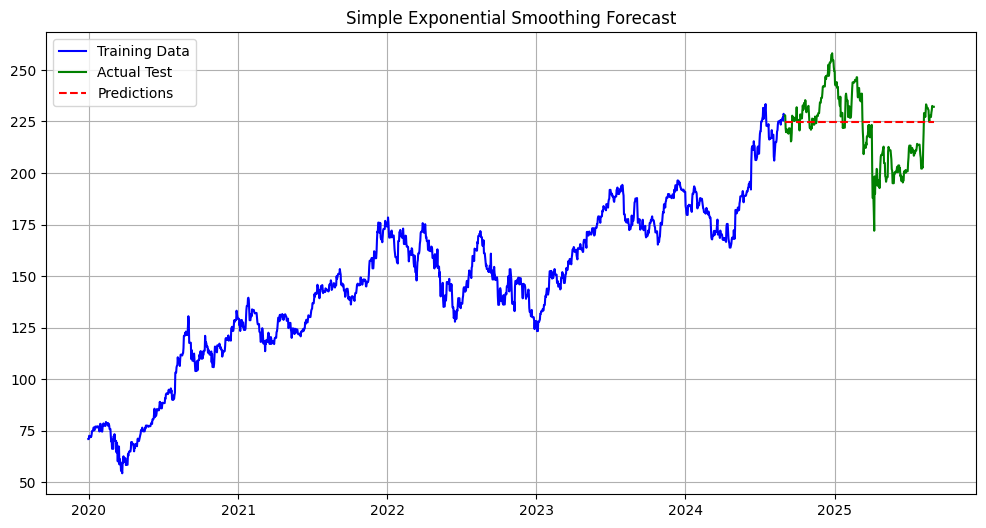

In [57]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.1, optimized=False)
print(ses_model.summary())
ses_pred = ses_model.forecast(len(test))
print("Simple Exponential Smoothing Forecast Value: ", ses_pred.unique()[0])

# Calculate Error Metrics
ses_mae = mean_absolute_error(test, ses_pred)
ses_rmse = np.sqrt(mean_squared_error(test, ses_pred))
ses_mape = mean_absolute_percentage_error(test, ses_pred)
ses_mase = mase(test, ses_pred, train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, ses_pred, label='Predictions', color='red', linestyle='--')
plt.title("Simple Exponential Smoothing Forecast")
plt.legend()
plt.grid(True)
plt.show()


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 1706
Model:             ExponentialSmoothing   SSE                          39072.188
Optimized:                        False   AIC                           5349.929
Trend:                         Additive   BIC                           5371.696
Seasonal:                          None   AICC                          5349.978
Seasonal Periods:                  None   Date:                 Sun, 14 Sep 2025
Box-Cox:                          False   Time:                         13:03:24
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
smoothing_trend            0.10000

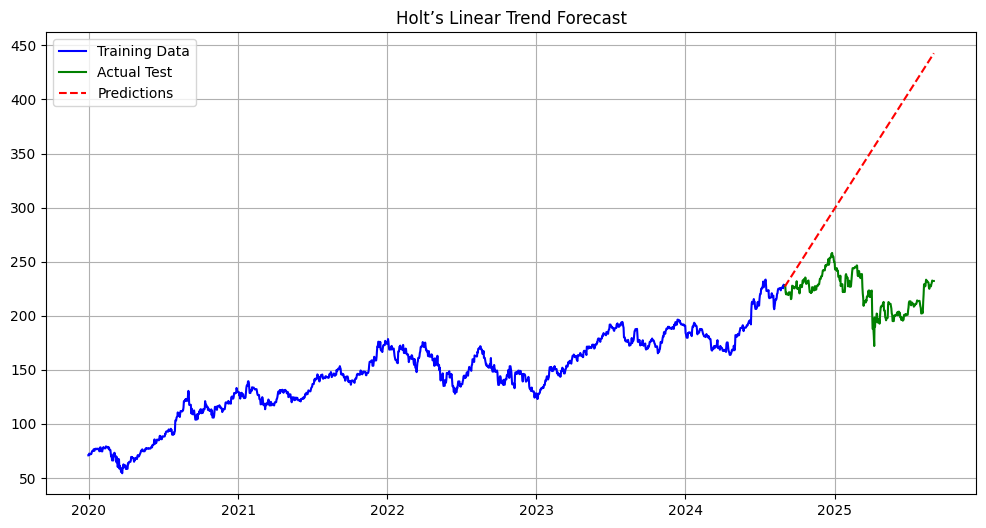

In [58]:
# Holt’s Linear Trend
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=0.1, smoothing_trend=0.1, optimized=False)
print(holt_model.summary())
holt_pred = holt_model.forecast(len(test))

# Calculate Error Metrics
holt_mae = mean_absolute_error(test, holt_pred)
holt_rmse = np.sqrt(mean_squared_error(test, holt_pred))
holt_mape = mean_absolute_percentage_error(test, holt_pred)
holt_mase = mase(test, holt_pred, train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, holt_pred, label='Predictions', color='red', linestyle='--')
plt.title("Holt’s Linear Trend Forecast")
plt.legend()
plt.grid(True)
plt.show()


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 1706
Model:             ExponentialSmoothing   SSE                          36681.674
Optimized:                        False   AIC                           5256.223
Trend:                         Additive   BIC                           5316.084
Seasonal:                      Additive   AICC                          5256.438
Seasonal Periods:                     7   Date:                 Sun, 14 Sep 2025
Box-Cox:                          False   Time:                         13:03:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          

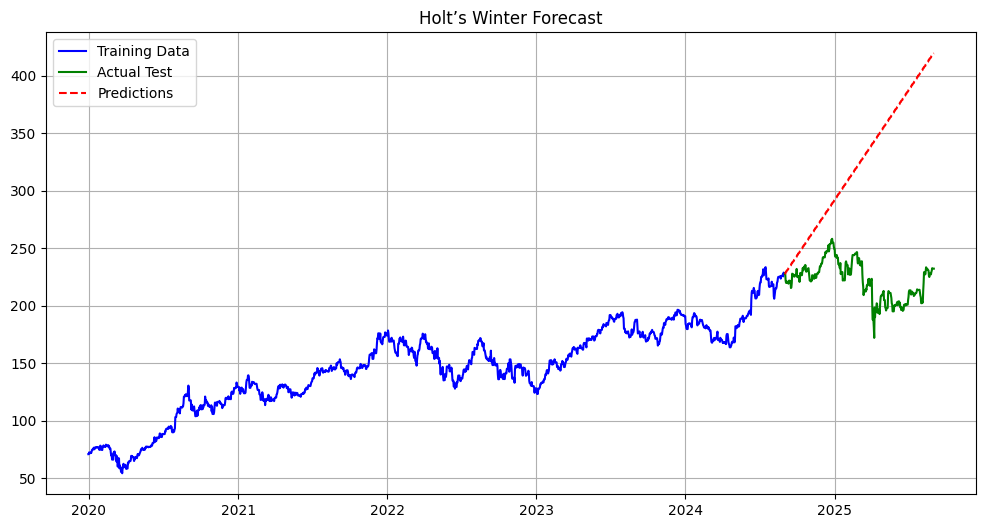

In [59]:
# Holt’s Winter
holt_winter_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.1, optimized=False)
print(holt_winter_model.summary())
holt_winter_pred = holt_winter_model.forecast(len(test))

# Calculate Error Metrics
holt_winter_mae = mean_absolute_error(test, holt_winter_pred)
holt_winter_rmse = np.sqrt(mean_squared_error(test, holt_winter_pred))
holt_winter_mape = mean_absolute_percentage_error(test, holt_winter_pred)
holt_winter_mase = mase(test,holt_winter_pred, train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, holt_winter_pred, label='Predictions', color='red', linestyle='--')
plt.title("Holt’s Winter Forecast")
plt.legend()
plt.grid(True)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7526.154, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7527.172, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7527.136, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7527.148, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7528.491, Time=1.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.867 seconds
Stepwise Fit Summary :                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1706
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3761.077
Date:                Sun, 14 Sep 2025   AIC                           7526.154
Time:                        13:03:27   BIC                           7537.037
Sample:                    12-31-2019   HQIC                          7530.182
                         - 08-31-2024                

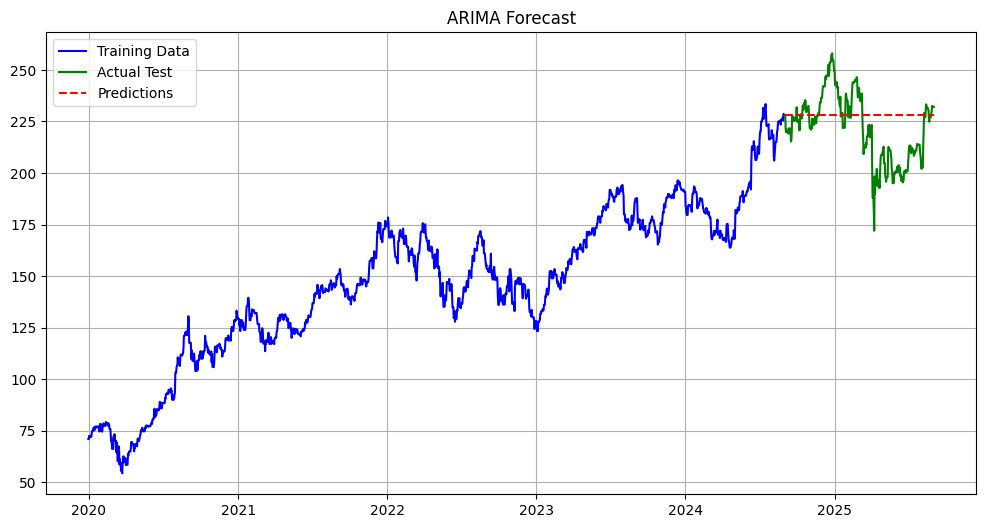

In [60]:
# Stepwise search for best ARIMA parameters
stepwise_fit = auto_arima(train,
                         start_p=0, start_q=0,
                         max_p=5, max_q=5, m=12,  # m=12 for monthly data
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print("Stepwise Fit Summary :", stepwise_fit.summary())

# ARIMA
arima_model = ARIMA(train, order=stepwise_fit.order)
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test))

# Calculate Error Metrics
arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mape = mean_absolute_percentage_error(test, arima_pred)
arima_mase = mase(test, arima_pred, train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, arima_pred, label='Predictions', color='red', linestyle='--')
plt.title("ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()


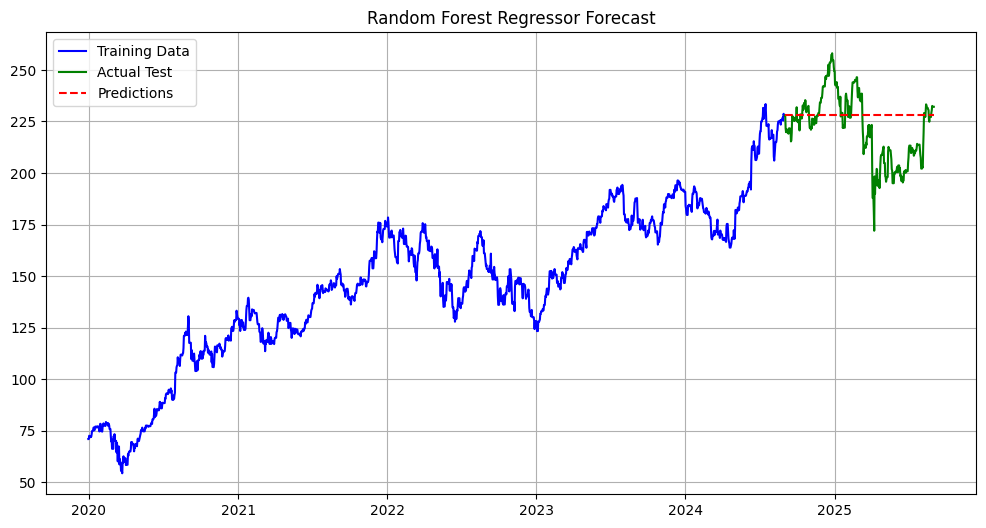

In [61]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 
rf_model.fit(train.index.values.reshape(-1, 1), train[metric_of_importance].values.reshape(-1, 1))
rf_pred = rf_model.predict(test.index.values.reshape(-1, 1))

# Calculate Error Metrics
rf_mae = mean_absolute_error(test[metric_of_importance], rf_pred)
rf_rmse = np.sqrt(mean_squared_error(test[metric_of_importance], rf_pred))
rf_mape = mean_absolute_percentage_error(test[metric_of_importance], rf_pred)
rf_mase = mase(test[metric_of_importance], rf_pred, train[metric_of_importance])

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, rf_pred, label='Predictions', color='red', linestyle='--')
plt.title("Random Forest Regressor Forecast")
plt.legend()
plt.grid(True)
plt.show()


13:03:29 - cmdstanpy - INFO - Chain [1] start processing
13:03:32 - cmdstanpy - INFO - Chain [1] done processing


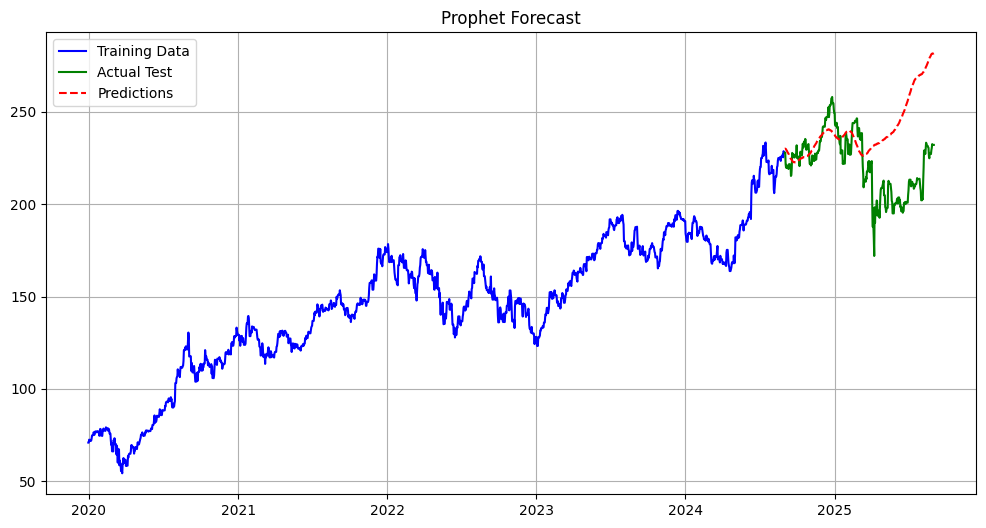

In [62]:
# Prophet
m = Prophet()
m.fit(train.reset_index().rename(columns={'index': 'ds', metric_of_importance: 'y'}))
forecast = m.predict(test.reset_index().rename(columns={'index': 'ds', 'Close': 'y'}))

# Calculate Error Metrics
prophet_mae = mean_absolute_error(test, forecast['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(test, forecast['yhat']))
prophet_mape = mean_absolute_percentage_error(test, forecast['yhat'])
prophet_mase = mase(test, forecast['yhat'], train)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, forecast['yhat'], label='Predictions', color='red', linestyle='--')
plt.title("Prophet Forecast")
plt.legend()
plt.grid(True)
plt.show()



### Question 4

#### Forecasting Accuracies

In [63]:
# Create an empty dataframe to store the Evaluation results
models_results = pd.DataFrame(columns=["Model", "MAE", "RMSE", "MAPE", "MASE"])

# Append the result of the Moving Average
models_results.loc[len(models_results)] = ["Moving Average", ma_mae, ma_rmse, ma_mape, ma_mase]
# Append the result of the Simple Exponential Smoothing
models_results.loc[len(models_results)] = ["SES", ses_mae, ses_rmse, ses_mape, ses_mase]
# Append the result of the Holt
models_results.loc[len(models_results)] = ["Holt", holt_mae, holt_rmse, holt_mape, holt_mase]
# Append the result of the Moving Average
models_results.loc[len(models_results)] = ["Holt's Winter", holt_winter_mae, holt_winter_rmse, holt_winter_mape, holt_winter_mase]
# Append the result of the Moving Average
models_results.loc[len(models_results)] = [f"ARIMA {stepwise_fit.order}", arima_mae, arima_rmse, arima_mape, arima_mase]
# Append the result of the Random Forest Regressor
models_results.loc[len(models_results)] = ["Random Forest Regressor", rf_mae, rf_rmse, rf_mape, rf_mase]
# Append the result of the Prophet
models_results.loc[len(models_results)] = ["Prophet", prophet_mae, prophet_rmse, prophet_mape, prophet_mase]

In [64]:

models_results.sort_values(by=['MAE','RMSE','MAPE','MASE'], ascending=True)

,Model,MAE,RMSE,MAPE,MASE
1,SES,13.424662,16.566174,0.062171,6.843155e+06
4,"ARIMA (0, 1, 0)",13.798607,17.409564,0.064709,7.033771e+06
5,Random Forest Regressor,13.810250,17.425099,0.064773,1.923417e+04
0,Moving Average,21.908170,26.201276,0.094782,1.116758e+07
6,Prophet,22.894450,30.457529,0.108228,1.164091e+07
3,Holt's Winter,101.882364,120.916607,0.476559,5.211001e+07
2,Holt,113.013376,133.892355,0.528148,5.777653e+07


### Question 5
#### Cross Validation and Performance

In [65]:
def calculate_metrics(y_true, y_pred, y_train, metric_of_importance):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred)
    metrics['MASE'] = mase(y_true, y_pred, y_train[metric_of_importance])
    return metrics

In [66]:
def time_series_cv(data, metric_of_importance, n_splits=5):
    # Initialize results storage
    results = {
        'MovingAverage': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'SES': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'Holt': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'HoltWinters': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'ARIMA': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'RandomForest': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []},
        'Prophet': {'MAE': [], 'RMSE': [], 'MAPE': [], 'MASE': []}
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    i = 1
    for train_idx, test_idx in tscv.split(data):
        train = data.iloc[train_idx]
        test = data.iloc[test_idx]

        print("\nIteration: ", i, "\nTraining dataset size: ", len(train), "\nTesting dataset size: ", len(test))
        # 1. Moving Average
        if 'MovingAverage' in results:
            ma_window = 150
            ma_forecast = train[metric_of_importance].rolling(ma_window).mean().iloc[-1]
            ma_pred = np.repeat(ma_forecast, len(test))
            metrics = calculate_metrics(test[metric_of_importance], ma_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['MovingAverage'][k].append(v)
            print(" Moving Average : Completed")

        # 2. Simple Exponential Smoothing
        if 'SES' in results:
            ses_model = SimpleExpSmoothing(train[metric_of_importance]).fit(optimized=True)
            ses_pred = ses_model.forecast(len(test))
            metrics = calculate_metrics(test[metric_of_importance], ses_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['SES'][k].append(v)
            print(" Simple Exponential Smoothing : Completed")

        # 3. Holt's Linear Trend
        if 'Holt' in results:
            holt_model = ExponentialSmoothing(
                    train[metric_of_importance],
                    trend='add',
                    seasonal=None
                ).fit(optimized=True)
            holt_pred = holt_model.forecast(len(test))
            metrics = calculate_metrics(test[metric_of_importance], holt_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['Holt'][k].append(v)
            print(" Holt's Linear Trend : Completed")

        # 4. Holt-Winters
        if 'HoltWinters' in results:
            holt_winter_model = ExponentialSmoothing(
                    train[metric_of_importance],
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12
                ).fit(optimized=True)
            holt_winter_pred = holt_winter_model.forecast(len(test))
            metrics = calculate_metrics(test[metric_of_importance], holt_winter_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['HoltWinters'][k].append(v)
            print(" Holt-Winters : Completed")

        # 5. ARIMA
        if 'ARIMA' in results:
            stepwise_fit = auto_arima(
                    train[metric_of_importance],
                    start_p=0, start_q=0,
                    max_p=5, max_q=5, m=12,
                    seasonal=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True
                )
            arima_model = ARIMA(
                train[metric_of_importance],
                order=stepwise_fit.order
            )
            arima_fit = arima_model.fit()
            arima_pred = arima_fit.forecast(len(test))
            metrics = calculate_metrics(test[metric_of_importance], arima_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['ARIMA'][k].append(v)
            print(" ARIMA : Completed")

        # 6. Random Forest
        if 'RandomForest' in results:
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_model.fit(
                train.index.values.reshape(-1, 1),
                train[metric_of_importance].values.reshape(-1, 1).ravel()
            )
            rf_pred = rf_model.predict(test.index.values.reshape(-1, 1))
            metrics = calculate_metrics(test[metric_of_importance], rf_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['RandomForest'][k].append(v)
            print(" Random Forest : Completed")

        # 7. Prophet
        if 'Prophet' in results:
            m = Prophet()
            train_prophet = train.reset_index().rename(columns={'index': 'ds', metric_of_importance: 'y'})
            m.fit(train_prophet)
            future = m.make_future_dataframe(periods=len(test))
            forecast = m.predict(future)
            prophet_pred = forecast['yhat'].iloc[-len(test):].values
            metrics = calculate_metrics(test[metric_of_importance], prophet_pred, train, metric_of_importance)
            for k, v in metrics.items():
                results['Prophet'][k].append(v)
            print(" Prophet : Completed")
            i += 1
    # Calculate mean and std for each metric
    final_results = {}
    for model_name, metrics in results.items():
        final_results[model_name] = {}
        for metric_name, values in metrics.items():
            if values:  # Only if we have values
                final_results[model_name][f'{metric_name}_mean'] = np.mean(values)
                final_results[model_name][f'{metric_name}_std'] = np.std(values)

    return pd.DataFrame(final_results).T

In [67]:
results_df = time_series_cv(data, metric_of_importance, n_splits=5)


Iteration:  1 
Training dataset size:  347 
Testing dataset size:  345
 Moving Average : Completed
 Simple Exponential Smoothing : Completed
 Holt's Linear Trend : Completed
 Holt-Winters : Completed
 ARIMA : Completed


13:03:41 - cmdstanpy - INFO - Chain [1] start processing


 Random Forest : Completed


13:03:41 - cmdstanpy - INFO - Chain [1] done processing


 Prophet : Completed

Iteration:  2 
Training dataset size:  692 
Testing dataset size:  345
 Moving Average : Completed
 Simple Exponential Smoothing : Completed
 Holt's Linear Trend : Completed
 Holt-Winters : Completed
 ARIMA : Completed


13:03:46 - cmdstanpy - INFO - Chain [1] start processing


 Random Forest : Completed


13:03:46 - cmdstanpy - INFO - Chain [1] done processing


 Prophet : Completed

Iteration:  3 
Training dataset size:  1037 
Testing dataset size:  345
 Moving Average : Completed
 Simple Exponential Smoothing : Completed
 Holt's Linear Trend : Completed
 Holt-Winters : Completed
 ARIMA : Completed
 Random Forest : Completed


13:03:55 - cmdstanpy - INFO - Chain [1] start processing
13:03:58 - cmdstanpy - INFO - Chain [1] done processing


 Prophet : Completed

Iteration:  4 
Training dataset size:  1382 
Testing dataset size:  345
 Moving Average : Completed
 Simple Exponential Smoothing : Completed
 Holt's Linear Trend : Completed
 Holt-Winters : Completed
 ARIMA : Completed


13:04:09 - cmdstanpy - INFO - Chain [1] start processing


 Random Forest : Completed


13:04:11 - cmdstanpy - INFO - Chain [1] done processing


 Prophet : Completed

Iteration:  5 
Training dataset size:  1727 
Testing dataset size:  345
 Moving Average : Completed
 Simple Exponential Smoothing : Completed
 Holt's Linear Trend : Completed
 Holt-Winters : Completed
 ARIMA : Completed


13:04:15 - cmdstanpy - INFO - Chain [1] start processing


 Random Forest : Completed


13:04:16 - cmdstanpy - INFO - Chain [1] done processing


 Prophet : Completed


In [68]:
results_df.sort_values(list(results_df.columns))

,MAE_mean,MAE_std,RMSE_mean,RMSE_std,MAPE_mean,MAPE_std,MASE_mean,MASE_std
RandomForest,15.284295,3.181630,18.890560,4.291828,0.087881,0.018734,14317.267961,6249.105599
ARIMA,15.333662,3.196847,18.984864,4.280898,0.088225,0.019046,14358.878433,6264.791578
SES,15.335279,3.196399,18.986399,4.280455,0.088236,0.019056,14359.531920,6263.893922
HoltWinters,16.974063,6.531960,20.811790,8.597160,0.102103,0.040021,16401.878691,10313.633411
Holt,17.063775,6.565359,20.919113,8.632974,0.102733,0.040365,16461.171100,10346.931517
MovingAverage,18.325294,2.560263,21.946371,2.592163,0.105888,0.030978,16501.439839,6015.534196
Prophet,22.903194,12.138352,27.901429,14.505799,0.131901,0.068345,23063.021817,14193.335001


### Question 6

**Summary**

This report summarizes the time series analysis performed on Apple Inc. (AAPL) stock price data from January 2020 to June 2024, and the forecast for the next 365 days.

**Findings:**

*   The stock price data shows a clear upward trend over the analyzed period.
*   No significant annual seasonality was observed in the data.
*   The residuals of the STL decomposition were found to be stationary (white noise) based on the ADF test.
*   Both ACF and PACF plots indicated significant autocorrelation in the 'Close' price.
*   Several forecasting models were evaluated, including Moving Average, Simple Exponential Smoothing (SES), Holt's Linear Trend, Holt-Winters, ARIMA, Random Forest Regressor, and Prophet.
*   Based on the initial evaluation on a single train-test split, ARIMA, SES, and Random Forest Regressor showed the lowest error metrics (MAE, RMSE, MAPE, MASE).
*   Cross-validation results similar order of model performance metric as we found in the our intial evaluation on a single train-test split.

**Challenges:**

*   Handling missing data points (weekends and holidays) required reindexing the time series and backfilling values to ensure continuity.
*   The inherent volatility and unpredictable nature of stock prices make accurate long-term forecasting difficult. 
*   Lack of External Variable that may influence Stock price lead high deviation in the test data. One clear example is the lack on info on Trump Tarif related imapact of stock prices since 2025 beginning was not possible to capture in the model which is why we see higher forecast then the test actual close price data


**Recommendations:**

*   Consider ensemble methods that combine predictions from multiple models to potentially improve forecasting accuracy.
*   Explore incorporating external factors and news sentiment that could influence stock prices into the models.
*   Continuously monitor and re-evaluate model performance as new data becomes available.
*   Further investigate the optimal parameters for each model using techniques like grid search within the cross-validation framework.
*   While the cross-validation results provide insights into model robustness, the ultimate choice of model for the 365-day forecast should consider a balance of all evaluation metrics and the specific goals of the forecasting exercise.